# Orbital test case
## Free fall
The first test that we are conducting is the simplest of all: the free fall. For this test, we consider a very simple object (a ball) that will be dropped from a high altitude above the sea level and JSBSim will compute its trajectory as the ball falls.

In [1]:
import jsbsim
fdm = jsbsim.FGFDMExec(root_dir="./") # We need to specify the current directory as ./
fdm.set_aircraft_path('../aircraft')
fdm.set_engine_path('../engine')
fdm.set_systems_path('../systems')

True

In [2]:
fdm.load_model('ball')

True

In [3]:
fdm.set_property_value('ic/h-sl-ft', 800000.)
fdm.set_property_value('simulation/gravity-model', 0) # Use standard gravity (spherical Earth)
fdm.run_ic()

True

In [4]:
fdm.set_property_value('simulation/write-state-file',1)
f = open('../aircraft/ball/initfile.0.xml','r')
print f.read()
f.close()

<?xml version="1.0"?>
<initialize name="reset00">
  <ubody unit="FT/SEC"> 0 </ubody> 
  <vbody unit="FT/SEC"> 0 </vbody> 
  <wbody unit="FT/SEC"> 0 </wbody> 
  <phi unit="DEG"> 0 </phi>
  <theta unit="DEG"> 1.27222e-14 </theta>
  <psi unit="DEG"> 0 </psi>
  <longitude unit="DEG"> 0 </longitude>
  <latitude unit="DEG"> 0 </latitude>
  <altitude unit="FT"> 800000 </altitude>
</initialize>



In [5]:
time = [fdm.get_property_value('simulation/sim-time-sec')]
alt = [fdm.get_property_value('position/h-sl-ft')]
vel = [fdm.get_property_value('velocities/h-dot-fps')]
grav = [fdm.get_property_value('accelerations/gravity-ft_sec2')]
print time, alt, vel, grav

[0.0] [799999.9999999963] [-0.0] [29.822735522824964]


In [6]:
while time[-1] < 250.0:
    fdm.run()
    time += [fdm.get_property_value('simulation/sim-time-sec')]
    alt += [fdm.get_property_value('position/h-sl-ft')]
    vel += [fdm.get_property_value('velocities/h-dot-fps')]
    grav += [fdm.get_property_value('accelerations/gravity-ft_sec2')]
    if fdm.get_property_value('gear/unit/WOW'):
        print "Hit the ground at %fs" % (time[-1],)
        break

Hit the ground at 230.650000s


Assuming that the gravity is constant and equal to $g$, one can deduce how the altitude changes along the time by applying Newton 2nd Law:

In [24]:
import sympy
sympy.init_printing()
m,g,t,h0 = sympy.symbols('m,g,t,h0')
h = sympy.Function('h')(t)

class Eq(sympy.Eq):
    def __mul__(self, other):
        return Eq(self.args[0].__mul__(other), self.args[1].__mul__(other))
    def __div__(self, other):
        return Eq(self.args[0].__div__(other), self.args[1].__div__(other))
    
def integrate(eq, f, v, x0, y0):
    """ Integrate the equation 'eq' and solve for the constant in the integrated 'eq'
    such that f(x0)=y0 when v=x0
    
    Example
    =======
    >>> import sympy
    >>> from sympy import Function, diff
    >>> from sympy.abc import x, y
    >>> f = Function('f')(x)
    >>> integrate(diff(f,x)-y, f, x, 0, 1)
    h(t) == y*t + 1
    """
    integ = sympy.integrate(eq, v)
    k0 = sympy.Symbol('k0')
    expr = integ.subs(f,y0-k0) # Substitute the function 
    expr = expr.subs(v,x0) # Replace the variable by its value
    k0 = sympy.solve(expr,k0)[0] # Solve for the constant
    rhs = sympy.solve(integ, f)[0] # Extract the rhs member so that the final equation is f = rhs + k0
    return Eq(f, rhs + k0)

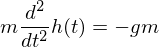

In [25]:
Newton = Eq(m*sympy.diff(h,t,2),-m*g)
Newton

The altitude $h$ and the velocity $v$ are then equal to

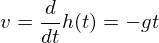

In [26]:
v = integrate(Newton/m, sympy.Derivative(h,t), t, 0, 0)
Eq(sympy.Symbol('v'),v)

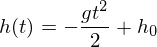

In [27]:
integrate(v, h, t, 0, h0)

In [28]:
import numpy as np
height = sympy.lambdify(t, Out[27].args[1].subs(g, grav[0]).subs(h0, alt[0]), "numpy")(np.array(time))
hdot = sympy.lambdify(t, v.args[1].subs(g, grav[0]), "numpy")(np.array(time))
dv = np.array(vel)-hdot

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt


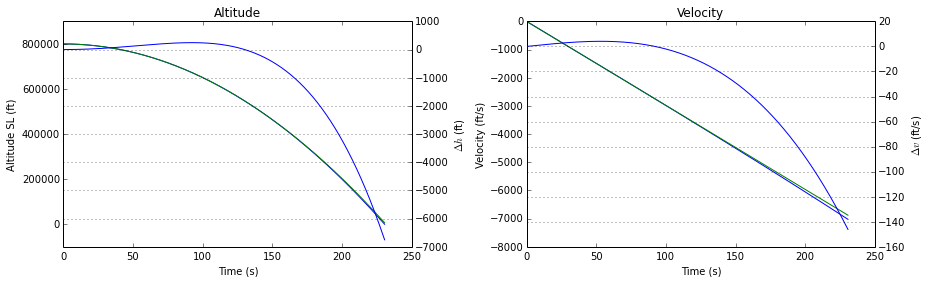

In [29]:
plt.figure(num=1, figsize=(13,4))
ax1 = plt.subplot(121)
ax1.plot(time,alt)
ax1.plot(time,height)
plt.title("Altitude")
plt.xlabel('Time (s)')
ax1.set_ylabel('Altitude SL (ft)')
ax2 = ax1.twinx()
ax2.plot(time,np.array(alt)-height)
ax2.set_ylabel('$\Delta h$ (ft)')
plt.grid(True)
ax1 = plt.subplot(122)
ax1.plot(time,vel)
ax1.plot(time,hdot)
plt.title("Velocity")
plt.xlabel('Time (s)')
ax1.set_ylabel('Velocity (ft/s)')
ax2 = ax1.twinx()
ax2.plot(time,dv)
ax2.set_ylabel('$\Delta v$ (ft/s)')
plt.tight_layout()
plt.grid(True);

There is an obvious mismatch between the values computed by JSBSim and the theoretical expressions that we obtained. A closer examination of the figure below shows that the gravity is not constant along the fall. So we will need to revisit our evaluation for better precision.

First, we will check that the gravity computed by JSBSim behaves like the classical Newtonian law $-GM/r^2$

In [33]:
GM = 14.0764417572E15
R0 = fdm.get_property_value('metrics/terrain-radius')
accel_g = GM / (R0 + np.array(alt))**2

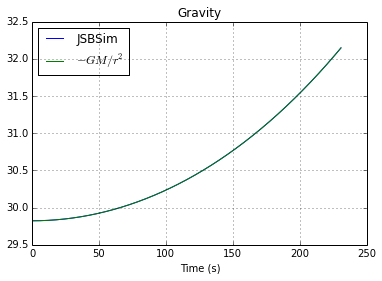

In [34]:
plt.figure(2)
plt.plot(time,grav,label="JSBSim")
plt.plot(time,accel_g,label="$-GM/r^2$")
plt.title("Gravity")
plt.xlabel('Time (s)')
plt.legend(loc=2)
plt.grid(True);

In the resolution of the 2nd law of Newton, we need to take into account the fact that the gravity is evolving along the fall.

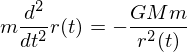

In [31]:
r = sympy.Function('r')(t)
G, M = sympy.symbols('G,M')
Newton2 = Eq(m*sympy.diff(r,t,2),-G*M*m/r**2)
Newton2

Multiplying both sides by $\dot{r}$ and integrating gives

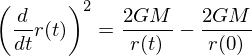

In [46]:
integrate(Newton2/m*sympy.diff(r,t),sympy.Derivative(r,t)**2,t,0,0)

and

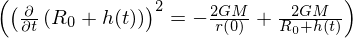

In [81]:
R0 = sympy.Symbol('R0')
xx = Out[32].subs(r,R0+h)
sympy.Mul.make_args(sympy.sympify(xx))
#Eq(xx.args[0].func(sympy.diff(xx.args[0].args[0].args[0],t),2),xx.args[1])

$\dot{h} = \sqrt{\frac{2GM}{R_0+h}-\frac{2GM}{R_0+h_0}}$

In [18]:
K = -2.0*GM/(R0+alt[0])
hdot2 = 2.0*GM/(R0+np.array(alt))+K
hdot = -np.sqrt(map(abs,hdot2)) # To work around negative values resulting from floating point errors (?)

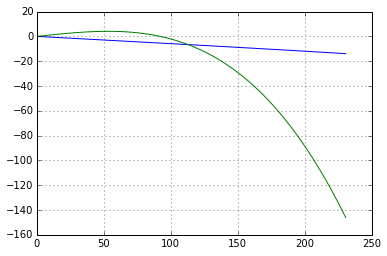

In [19]:
plt.figure(3)
plt.plot(time,hdot-np.array(vel))
plt.plot(time,dv)
plt.grid(True);

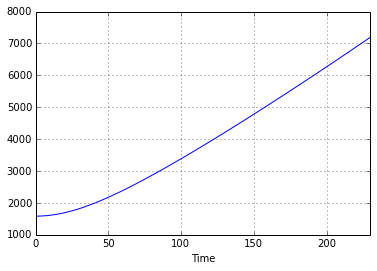

In [24]:
import pandas
csv = pandas.read_csv('BallOut.csv',index_col='Time')
csv['V_{Inertial} (ft/s)'].plot();
#csv.columns

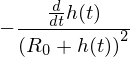

In [25]:
import sympy
sympy.init_printing()
R0, t, GM, K = sympy.symbols('R0,t,GM,K')
h = sympy.Function('h')(t)
sympy.diff(1/(R0+h),t)

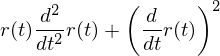

In [26]:
r = sympy.Function('r')(t)
expr = sympy.diff(r**2,t,2)/2
subexpr = expr.args[0]
expr

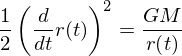

In [27]:
Newton = sympy.Eq(sympy.diff(r,t,2),-GM/r**2)
N2 = Newton.func(sympy.diff(r,t)*Newton.args[0],sympy.diff(r,t)*Newton.args[1])
sympy.integrate(N2,t)

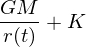

In [29]:
expr.func(subexpr.func(-GM/r**2,subexpr.args[1]),2*GM/r+K)

In [33]:
h

In [31]:
fdm.reset_to_initial_conditions(1)
fdm.get_property_value('metrics/terrain-radius')